**1. Loading the AI-Ready Data**

In [36]:
# 1. Data Loading and Preparation
import zipfile
import os
import xarray as xr

# Define data paths
my_path = '/Users/Joey/Downloads/' # CHANGE ME TO BE YOUR PATH TO DATA
zip_file_path = os.path.join(my_path, 'ready_sic_sst_data.zip')
ds_path = os.path.join(my_path, 'ready_sic_sst_data.nc')

# Unzip data if not already extracted
if os.path.exists(zip_file_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(my_path)
    print('Data extracted successfully!')

# Load the .nc file
ds = xr.open_dataset(ds_path)
ds


Data extracted successfully!


<xarray.Dataset> Size: 85MB
Dimensions:    (time: 46, latitude: 160, longitude: 1440)
Coordinates:
    number     int64 8B ...
  * time       (time) datetime64[ns] 368B 1979-09-01 1980-09-01 ... 2024-09-01
  * latitude   (latitude) float64 1kB 90.0 89.75 89.5 89.25 ... 50.75 50.5 50.25
  * longitude  (longitude) float64 12kB -180.0 -179.8 -179.5 ... 179.5 179.8
    expver     (time) <U4 736B ...
Data variables:
    sst        (time, latitude, longitude) float32 42MB ...
    sic        (time, latitude, longitude) float32 42MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-25T20:05 GRIB to CDM+CF via cfgrib-0.9.1...

**2. Cross Validating and Train-Val-Test Splitting the Data**

In [37]:
# 2. Cross-Validation and Train-Val-Test Splitting
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit

# Convert xarray dataset to a DataFrame and drop missing values
df = ds.to_dataframe().dropna()

# Print the shape and first few rows of the full DataFrame
print("Full DataFrame shape:", df.shape)
print("First few rows of the DataFrame:\n", df.head())

# Set the time column as a level in the index if it is not already
df = df.set_index('time', append=True) if 'time' not in df.index.names else df

# Split data into training (1979-2010) and testing (2011 onward) based on the time index
train_data = df[df.index.get_level_values('time') < '2011-01-01']
test_data = df[df.index.get_level_values('time') >= '2011-01-01']

# Print the shape of the train and test sets
print("\nTrain data shape (1979-2010):", train_data.shape)
print("Test data shape (2011 onward):", test_data.shape)

# Display the first few rows of train and test data
print("\nFirst few rows of Train Data (1979-2010):\n", train_data.head())
print("\nFirst few rows of Test Data (2011 onward):\n", test_data.head())

# TimeSeriesSplit on the training data if further temporal validation is needed (CROSS-VALIDATION)
tscv = TimeSeriesSplit(n_splits=5)
split_number = 1
for train_index, val_index in tscv.split(train_data):
    # Create train and validation splits for this fold
    train_split, val_split = train_data.iloc[train_index], train_data.iloc[val_index]
    
    # Print the split details
    print(f"\n--- TimeSeriesSplit Fold {split_number} ---")
    print("Train split shape:", train_split.shape)
    print("Validation split shape:", val_split.shape)
    
    # Display the first few rows of train and val for this split
    print("First few rows of current Train Split:\n", train_split.head())
    print("First few rows of current Validation Split:\n", val_split.head())
    
    split_number += 1


Full DataFrame shape: (6319572, 4)
First few rows of the DataFrame:
                                number expver         sst       sic
time       latitude longitude                                     
1979-09-01 90.0     -180.00         0   0001  271.459961  0.926239
                    -179.75         0   0001  271.459961  0.926239
                    -179.50         0   0001  271.459961  0.926239
                    -179.25         0   0001  271.459961  0.926239
                    -179.00         0   0001  271.459961  0.926239

Train data shape (1979-2010): (4396224, 4)
Test data shape (2011 onward): (1923348, 4)

First few rows of Train Data (1979-2010):
                                number expver         sst       sic
time       latitude longitude                                     
1979-09-01 90.0     -180.00         0   0001  271.459961  0.926239
                    -179.75         0   0001  271.459961  0.926239
                    -179.50         0   0001  271.459961  0.92

**3. Performance Generality by Testing on Diverse Subsets of the Data**

In [38]:
# 3. Performance Generality by Testing on Diverse Subsets of the Data
import pandas as pd

# Assuming df is your original DataFrame (loaded from xarray and converted)
# Sample DataFrame preview (already provided):
#                    number expver         sst       sic
# time       latitude longitude
# 2012-09-01 83.25     109.25         0   0001  271.610840  0.398163

# Example of diverse subsets

# 1. Subset by different time periods
# For example: 1990-2000, 2001-2010, 2011-2020
subset_1990_2000 = df[(df.index.get_level_values('time') >= '1990-01-01') &
                      (df.index.get_level_values('time') <= '2000-12-31')]
subset_2001_2010 = df[(df.index.get_level_values('time') >= '2001-01-01') &
                      (df.index.get_level_values('time') <= '2010-12-31')]
subset_2011_2020 = df[(df.index.get_level_values('time') >= '2011-01-01') &
                      (df.index.get_level_values('time') <= '2020-12-31')]

print("Subset 1990-2000 shape:", subset_1990_2000.shape)
print("Subset 2001-2010 shape:", subset_2001_2010.shape)
print("Subset 2011-2020 shape:", subset_2011_2020.shape)

# 2. Subset by spatial location
# For example: data in the northern hemisphere only, or specific latitude/longitude ranges
subset_northern_hemisphere = df[df.index.get_level_values('latitude') > 0]
subset_longitude_range = df[(df.index.get_level_values('longitude') >= -50) &
                            (df.index.get_level_values('longitude') <= 50)]

print("Northern Hemisphere subset shape:", subset_northern_hemisphere.shape)
print("Longitude range (-50 to 50) subset shape:", subset_longitude_range.shape)

# 3. Subset by sea surface temperature (sst) range
# For example: cold (<273K), moderate (273-278K), and warm (>278K) SST values
subset_sst_cold = df[df['sst'] < 273]
subset_sst_moderate = df[(df['sst'] >= 273) & (df['sst'] <= 278)]
subset_sst_warm = df[df['sst'] > 278]

print("Cold SST subset shape:", subset_sst_cold.shape)
print("Moderate SST subset shape:", subset_sst_moderate.shape)
print("Warm SST subset shape:", subset_sst_warm.shape)

# 4. Subset by sea ice concentration (sic) levels
# For example: low (sic < 0.3), medium (0.3 <= sic <= 0.7), and high (sic > 0.7)
subset_sic_low = df[df['sic'] < 0.3]
subset_sic_medium = df[(df['sic'] >= 0.3) & (df['sic'] <= 0.7)]
subset_sic_high = df[df['sic'] > 0.7]

print("Low SIC subset shape:", subset_sic_low.shape)
print("Medium SIC subset shape:", subset_sic_medium.shape)
print("High SIC subset shape:", subset_sic_high.shape)

# Each subset can now be used to test model performance and generality.


Subset 1990-2000 shape: (1511202, 4)
Subset 2001-2010 shape: (1373820, 4)
Subset 2011-2020 shape: (1373820, 4)
Northern Hemisphere subset shape: (6319572, 4)
Longitude range (-50 to 50) subset shape: (1978598, 4)
Cold SST subset shape: (3315423, 4)
Moderate SST subset shape: (1084342, 4)
Warm SST subset shape: (1919807, 4)
Low SIC subset shape: (3268961, 4)
Medium SIC subset shape: (315278, 4)
High SIC subset shape: (2735333, 4)


**4. Bootstrapping and Bagging**

In [40]:
# 4. Bootstrapping and Bagging
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import resample

# Bootstrapping parameters
n_iterations = 10
train_errors, test_errors, oob_errors = [], [], []

# Store models and errors for each bootstrap iteration
models = []
metrics = {
    'train_mse': [], 'train_mae': [], 'train_r2': [],
    'test_mse': [], 'test_mae': [], 'test_r2': [],
    'oob_mse': [], 'oob_mae': [], 'oob_r2': []
}

# Separate features and target in test set for evaluation
X_test = test_data.drop('sst', axis=1)
y_test = test_data['sst']

# Bagging loop
for i in range(n_iterations):
    # Sample with replacement from the training set for bootstrap
    bootstrapped_data = train_data.sample(frac=1, replace=True, random_state=i)
    X_train = bootstrapped_data.drop('sst', axis=1)
    y_train = bootstrapped_data['sst']
    
    # Identify out-of-bag (OOB) samples for this iteration
    oob_data = train_data.loc[~train_data.index.isin(bootstrapped_data.index)]
    X_oob = oob_data.drop('sst', axis=1)
    y_oob = oob_data['sst']
    
    # Train the model on the bootstrap sample
    model = DecisionTreeRegressor(random_state=i)
    model.fit(X_train, y_train)
    
    # Store the trained model
    models.append(model)
    
    # Predict on train, test, and OOB data
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)
    oob_predictions = model.predict(X_oob)
    
    # Calculate metrics for train set
    train_mse = mean_squared_error(y_train, train_predictions)
    train_mae = mean_absolute_error(y_train, train_predictions)
    train_r2 = r2_score(y_train, train_predictions)
    
    # Calculate metrics for test set
    test_mse = mean_squared_error(y_test, test_predictions)
    test_mae = mean_absolute_error(y_test, test_predictions)
    test_r2 = r2_score(y_test, test_predictions)
    
    # Calculate metrics for OOB samples (if available)
    if not oob_data.empty:
        oob_mse = mean_squared_error(y_oob, oob_predictions)
        oob_mae = mean_absolute_error(y_oob, oob_predictions)
        oob_r2 = r2_score(y_oob, oob_predictions)
    else:
        oob_mse = oob_mae = oob_r2 = np.nan  # If no OOB samples
    
    # Append metrics
    metrics['train_mse'].append(train_mse)
    metrics['train_mae'].append(train_mae)
    metrics['train_r2'].append(train_r2)
    
    metrics['test_mse'].append(test_mse)
    metrics['test_mae'].append(test_mae)
    metrics['test_r2'].append(test_r2)
    
    metrics['oob_mse'].append(oob_mse)
    metrics['oob_mae'].append(oob_mae)
    metrics['oob_r2'].append(oob_r2)
    
    # Print the metrics for this bootstrap iteration
    print(f"Iteration {i+1}:")
    print(f"  Train MSE: {train_mse:.4f}, MAE: {train_mae:.4f}, R2: {train_r2:.4f}")
    print(f"  Test MSE: {test_mse:.4f}, MAE: {test_mae:.4f}, R2: {test_r2:.4f}")
    if not np.isnan(oob_mse):
        print(f"  OOB MSE: {oob_mse:.4f}, MAE: {oob_mae:.4f}, R2: {oob_r2:.4f}")
    else:
        print("  OOB data not available for this iteration")

# Calculate and display average metrics across all bootstraps
average_metrics = {key: np.nanmean(values) for key, values in metrics.items()}
print("\nAverage Metrics Across Bootstraps:")
for metric, value in average_metrics.items():
    print(f"{metric}: {value:.4f}")


Iteration 1:
  Train MSE: 8.2875, MAE: 1.6521, R2: 0.7048
  Test MSE: 11.6392, MAE: 2.1918, R2: 0.6138
  OOB MSE: 8.3072, MAE: 1.6584, R2: 0.7039
Iteration 2:
  Train MSE: 8.3042, MAE: 1.6541, R2: 0.7042
  Test MSE: 11.6377, MAE: 2.1917, R2: 0.6139
  OOB MSE: 8.3017, MAE: 1.6585, R2: 0.7042
Iteration 3:
  Train MSE: 8.2793, MAE: 1.6499, R2: 0.7049
  Test MSE: 11.6390, MAE: 2.1918, R2: 0.6139
  OOB MSE: 8.3294, MAE: 1.6623, R2: 0.7034
Iteration 4:
  Train MSE: 8.3058, MAE: 1.6537, R2: 0.7044
  Test MSE: 11.6394, MAE: 2.1919, R2: 0.6138
  OOB MSE: 8.2965, MAE: 1.6579, R2: 0.7040
Iteration 5:
  Train MSE: 8.3013, MAE: 1.6535, R2: 0.7044
  Test MSE: 11.6394, MAE: 2.1919, R2: 0.6138
  OOB MSE: 8.2999, MAE: 1.6583, R2: 0.7039
Iteration 6:
  Train MSE: 8.3019, MAE: 1.6531, R2: 0.7043
  Test MSE: 11.6383, MAE: 2.1917, R2: 0.6139
  OOB MSE: 8.2948, MAE: 1.6574, R2: 0.7043
Iteration 7:
  Train MSE: 8.3075, MAE: 1.6547, R2: 0.7041
  Test MSE: 11.6378, MAE: 2.1918, R2: 0.6139
  OOB MSE: 8.2918, MA

**5. Model Evaluation: Learning Curves and Performance Visualization**

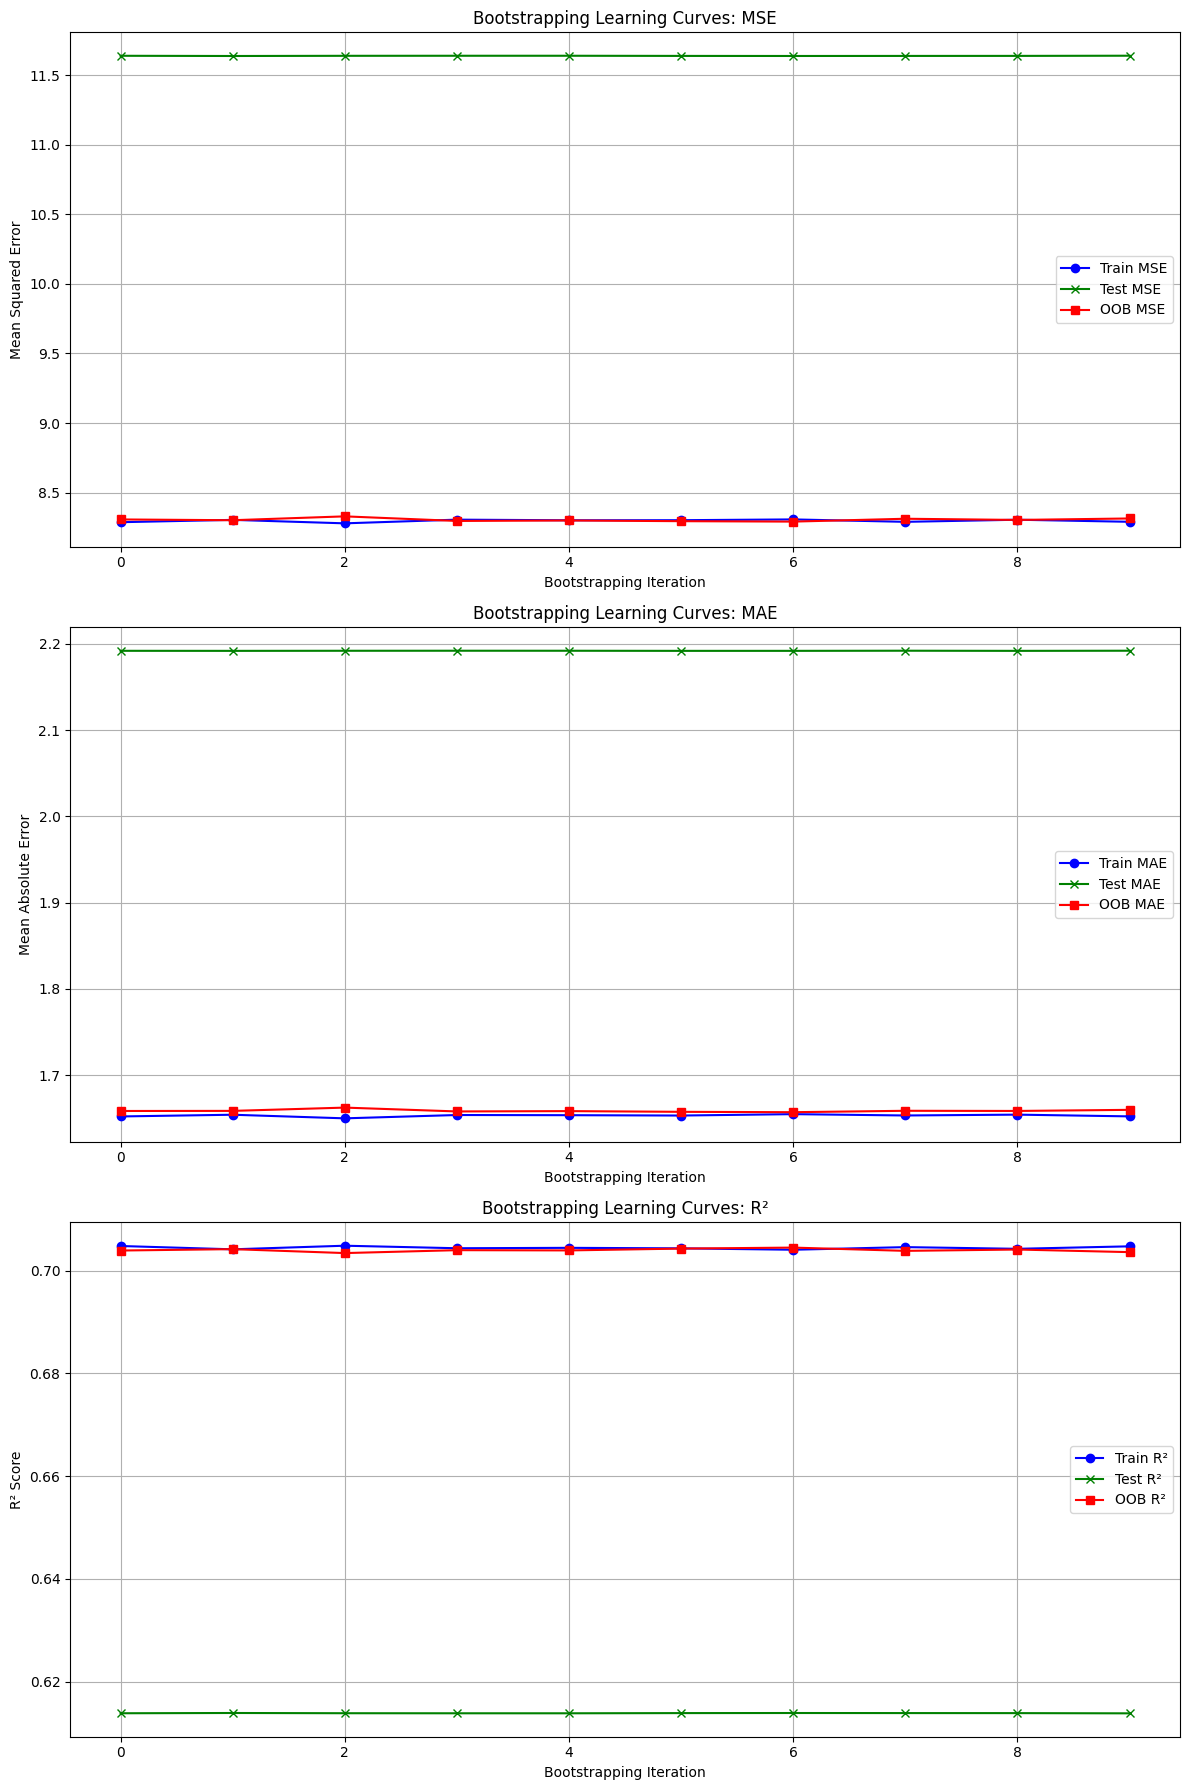

In [41]:
# 5. Model Evaluation: Learning Curves and Performance Visualization
import matplotlib.pyplot as plt

# Number of bootstrapping iterations
iterations = range(n_iterations)

# Plotting learning curves for Train, Test, and OOB MSE, MAE, and R²
fig, axs = plt.subplots(3, 1, figsize=(12, 18))

# Mean Squared Error (MSE) Learning Curves
axs[0].plot(iterations, metrics['train_mse'], label="Train MSE", color="blue", marker="o")
axs[0].plot(iterations, metrics['test_mse'], label="Test MSE", color="green", marker="x")
axs[0].plot(iterations, metrics['oob_mse'], label="OOB MSE", color="red", marker="s")
axs[0].set_xlabel("Bootstrapping Iteration")
axs[0].set_ylabel("Mean Squared Error")
axs[0].set_title("Bootstrapping Learning Curves: MSE")
axs[0].legend()
axs[0].grid(True)

# Mean Absolute Error (MAE) Learning Curves
axs[1].plot(iterations, metrics['train_mae'], label="Train MAE", color="blue", marker="o")
axs[1].plot(iterations, metrics['test_mae'], label="Test MAE", color="green", marker="x")
axs[1].plot(iterations, metrics['oob_mae'], label="OOB MAE", color="red", marker="s")
axs[1].set_xlabel("Bootstrapping Iteration")
axs[1].set_ylabel("Mean Absolute Error")
axs[1].set_title("Bootstrapping Learning Curves: MAE")
axs[1].legend()
axs[1].grid(True)

# R² Score Learning Curves
axs[2].plot(iterations, metrics['train_r2'], label="Train R²", color="blue", marker="o")
axs[2].plot(iterations, metrics['test_r2'], label="Test R²", color="green", marker="x")
axs[2].plot(iterations, metrics['oob_r2'], label="OOB R²", color="red", marker="s")
axs[2].set_xlabel("Bootstrapping Iteration")
axs[2].set_ylabel("R² Score")
axs[2].set_title("Bootstrapping Learning Curves: R²")
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()


**6. Subsetting to Barents-Kara Sea Region Based on our choice to use a Decision Tree Regressor**

In [42]:
# 6. Data Selection for Specific Regions
# Select data for Barents-Kara Sea region
ds_sel = ds.sel(latitude=slice('85.01', '65'), longitude=slice('30', '90.01'))
ds_sel


<xarray.Dataset> Size: 18MB
Dimensions:    (time: 46, latitude: 81, longitude: 600)
Coordinates:
    number     int64 8B 0
  * time       (time) datetime64[ns] 368B 1979-09-01 1980-09-01 ... 2024-09-01
  * latitude   (latitude) float64 648B 85.0 84.75 84.5 84.25 ... 65.5 65.25 65.0
  * longitude  (longitude) float64 5kB 30.0 30.25 30.5 ... 179.2 179.5 179.8
    expver     (time) <U4 736B '0001' '0001' '0001' ... '0001' '0001' '0005'
Data variables:
    sst        (time, latitude, longitude) float32 9MB 271.5 271.5 ... nan nan
    sic        (time, latitude, longitude) float32 9MB 0.8098 0.8085 ... nan nan
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-25T20:05 GRIB to CDM+CF via cfgrib-0.9.1...

**7. Splitting this Training Data as Desired. The first split (commented out) trains the model on data from 1979-2010 and tests it on data from 2011 onwards. The second split trains the model on all data and then tests it on 10 randomly selected years.**

In [43]:
# 7. Re-splitting the subset data for training and testing
'''import pandas as pd
from sklearn.model_selection import TimeSeriesSplit

# Convert xarray dataset to a DataFrame and drop missing values
df = ds_sel.to_dataframe().dropna()

# Print the shape and first few rows of the full DataFrame
print("Full DataFrame shape:", df.shape)
print("First few rows of the DataFrame:\n", df.head())

# Set the time column as a level in the index if it is not already
df = df.set_index('time', append=True) if 'time' not in df.index.names else df

# Split data into training (1979-2010) and testing (2011 onward) based on the time index
train_data = df[df.index.get_level_values('time') < '2011-01-01']
test_data = df[df.index.get_level_values('time') >= '2011-01-01']

# Print the shape of the train and test sets
print("\nTrain data shape (1979-2010):", train_data.shape)
print("Test data shape (2011 onward):", test_data.shape)

# Display the first few rows of train and test data
print("\nFirst few rows of Train Data (1979-2010):\n", train_data.head())
print("\nFirst few rows of Test Data (2011 onward):\n", test_data.head())

# Perform TimeSeriesSplit on the training data for cross-validation
tscv = TimeSeriesSplit(n_splits=5)
split_number = 1
for train_index, val_index in tscv.split(train_data):
    # Create train and validation splits for this fold
    train_split, val_split = train_data.iloc[train_index], train_data.iloc[val_index]
    
    # Print the split details
    print(f"\n--- TimeSeriesSplit Fold {split_number} ---")
    print("Train split shape:", train_split.shape)
    print("Validation split shape:", val_split.shape)
    
    # Display the first few rows of train and validation for this split
    print("First few rows of current Train Split:\n", train_split.head())
    print("First few rows of current Validation Split:\n", val_split.head())
    
    split_number += 1
'''

import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

# Convert xarray dataset to a DataFrame and drop missing values
df = ds_sel.to_dataframe().dropna()

# Print the shape and first few rows of the full DataFrame
print("Full DataFrame shape:", df.shape)
print("First few rows of the DataFrame:\n", df.head())

# Ensure 'time' is part of the index
df = df.set_index('time', append=True) if 'time' not in df.index.names else df

# Extract unique years from the 'time' index
years = pd.DatetimeIndex(df.index.get_level_values('time')).year.unique()

# Randomly select 10 years for testing
np.random.seed(42)  # For reproducibility
test_years = np.random.choice(years, size=10, replace=False)
print("Selected test years:", test_years)

# Split data based on the selected years
train_data = df[~df.index.get_level_values('time').year.isin(test_years)]
test_data = df[df.index.get_level_values('time').year.isin(test_years)]

# Print the shape of the train and test sets
print("\nTrain data shape (all years except selected test years):", train_data.shape)
print("Test data shape (selected 10 random years):", test_data.shape)

# Display the first few rows of train and test data
print("\nFirst few rows of Train Data (all years except selected test years):\n", train_data.head())
print("\nFirst few rows of Test Data (selected 10 random years):\n", test_data.head())

# Perform TimeSeriesSplit on the training data for cross-validation
tscv = TimeSeriesSplit(n_splits=5)
split_number = 1
for train_index, val_index in tscv.split(train_data):
    # Create train and validation splits for this fold
    train_split, val_split = train_data.iloc[train_index], train_data.iloc[val_index]
    
    # Print the split details
    print(f"\n--- TimeSeriesSplit Fold {split_number} ---")
    print("Train split shape:", train_split.shape)
    print("Validation split shape:", val_split.shape)
    
    # Display the first few rows of train and validation for this split
    print("First few rows of current Train Split:\n", train_split.head())
    print("First few rows of current Validation Split:\n", val_split.head())
    
    split_number += 1



Full DataFrame shape: (1449736, 4)
First few rows of the DataFrame:
                                number expver         sst       sic
time       latitude longitude                                     
1979-09-01 85.0     30.00           0   0001  271.459961  0.809814
                    30.25           0   0001  271.459961  0.808502
                    30.50           0   0001  271.459961  0.807190
                    30.75           0   0001  271.459961  0.805878
                    31.00           0   0001  271.459961  0.804565
Selected test years: [2018 2004 2005 2023 2014 2020 1983 1991 1987 1982]

Train data shape (all years except selected test years): (1134576, 4)
Test data shape (selected 10 random years): (315160, 4)

First few rows of Train Data (all years except selected test years):
                                number expver         sst       sic
time       latitude longitude                                     
1979-09-01 85.0     30.00           0   0001  271.459961 

**8. Bootstrapping the subsetted data. Note that we could have used any subsets from Step 2, and that these would likely have yielded different results.**

In [44]:
# 8. Bootstrapping and Bagging
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import resample

# Bootstrapping parameters
n_iterations = 10
train_errors, test_errors, oob_errors = [], [], []

# Store models and errors for each bootstrap iteration
models = []
metrics = {
    'train_mse': [], 'train_mae': [], 'train_r2': [],
    'test_mse': [], 'test_mae': [], 'test_r2': [],
    'oob_mse': [], 'oob_mae': [], 'oob_r2': []
}

# Separate features and target in test set for evaluation
X_test = test_data.drop('sst', axis=1)
y_test = test_data['sst']

# Bagging loop
for i in range(n_iterations):
    # Sample with replacement from the training set for bootstrap
    bootstrapped_data = train_data.sample(frac=1, replace=True, random_state=i)
    X_train = bootstrapped_data.drop('sst', axis=1)
    y_train = bootstrapped_data['sst']
    
    # Identify out-of-bag (OOB) samples for this iteration
    oob_data = train_data.loc[~train_data.index.isin(bootstrapped_data.index)]
    X_oob = oob_data.drop('sst', axis=1)
    y_oob = oob_data['sst']
    
    # Train the model on the bootstrap sample
    model = DecisionTreeRegressor(random_state=i)
    model.fit(X_train, y_train)
    
    # Store the trained model
    models.append(model)
    
    # Predict on train, test, and OOB data
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)
    oob_predictions = model.predict(X_oob)
    
    # Calculate metrics for train set
    train_mse = mean_squared_error(y_train, train_predictions)
    train_mae = mean_absolute_error(y_train, train_predictions)
    train_r2 = r2_score(y_train, train_predictions)
    
    # Calculate metrics for test set
    test_mse = mean_squared_error(y_test, test_predictions)
    test_mae = mean_absolute_error(y_test, test_predictions)
    test_r2 = r2_score(y_test, test_predictions)
    
    # Calculate metrics for OOB samples (if available)
    if not oob_data.empty:
        oob_mse = mean_squared_error(y_oob, oob_predictions)
        oob_mae = mean_absolute_error(y_oob, oob_predictions)
        oob_r2 = r2_score(y_oob, oob_predictions)
    else:
        oob_mse = oob_mae = oob_r2 = np.nan  # If no OOB samples
    
    # Append metrics
    metrics['train_mse'].append(train_mse)
    metrics['train_mae'].append(train_mae)
    metrics['train_r2'].append(train_r2)
    
    metrics['test_mse'].append(test_mse)
    metrics['test_mae'].append(test_mae)
    metrics['test_r2'].append(test_r2)
    
    metrics['oob_mse'].append(oob_mse)
    metrics['oob_mae'].append(oob_mae)
    metrics['oob_r2'].append(oob_r2)
    
    # Print the metrics for this bootstrap iteration
    print(f"Iteration {i+1}:")
    print(f"  Train MSE: {train_mse:.4f}, MAE: {train_mae:.4f}, R2: {train_r2:.4f}")
    print(f"  Test MSE: {test_mse:.4f}, MAE: {test_mae:.4f}, R2: {test_r2:.4f}")
    if not np.isnan(oob_mse):
        print(f"  OOB MSE: {oob_mse:.4f}, MAE: {oob_mae:.4f}, R2: {oob_r2:.4f}")
    else:
        print("  OOB data not available for this iteration")

# Calculate and display average metrics across all bootstraps
average_metrics = {key: np.nanmean(values) for key, values in metrics.items()}
print("\nAverage Metrics Across Bootstraps:")
for metric, value in average_metrics.items():
    print(f"{metric}: {value:.4f}")


Iteration 1:
  Train MSE: 2.8775, MAE: 0.9485, R2: 0.6373
  Test MSE: 3.7129, MAE: 1.1303, R2: 0.5812
  OOB MSE: 2.9424, MAE: 0.9706, R2: 0.6294
Iteration 2:
  Train MSE: 2.8718, MAE: 0.9469, R2: 0.6374
  Test MSE: 3.7162, MAE: 1.1302, R2: 0.5809
  OOB MSE: 2.9564, MAE: 0.9734, R2: 0.6285
Iteration 3:
  Train MSE: 2.8833, MAE: 0.9492, R2: 0.6373
  Test MSE: 3.7128, MAE: 1.1304, R2: 0.5812
  OOB MSE: 2.9562, MAE: 0.9736, R2: 0.6282
Iteration 4:
  Train MSE: 2.8901, MAE: 0.9496, R2: 0.6373
  Test MSE: 3.7146, MAE: 1.1315, R2: 0.5811
  OOB MSE: 2.9343, MAE: 0.9712, R2: 0.6289
Iteration 5:
  Train MSE: 2.8889, MAE: 0.9511, R2: 0.6374
  Test MSE: 3.7121, MAE: 1.1305, R2: 0.5813
  OOB MSE: 2.9412, MAE: 0.9706, R2: 0.6289
Iteration 6:
  Train MSE: 2.8825, MAE: 0.9483, R2: 0.6381
  Test MSE: 3.7116, MAE: 1.1305, R2: 0.5814
  OOB MSE: 2.9480, MAE: 0.9739, R2: 0.6283
Iteration 7:
  Train MSE: 2.8837, MAE: 0.9486, R2: 0.6369
  Test MSE: 3.7170, MAE: 1.1310, R2: 0.5808
  OOB MSE: 2.9491, MAE: 0.97

**9. Evaluating the subset data**

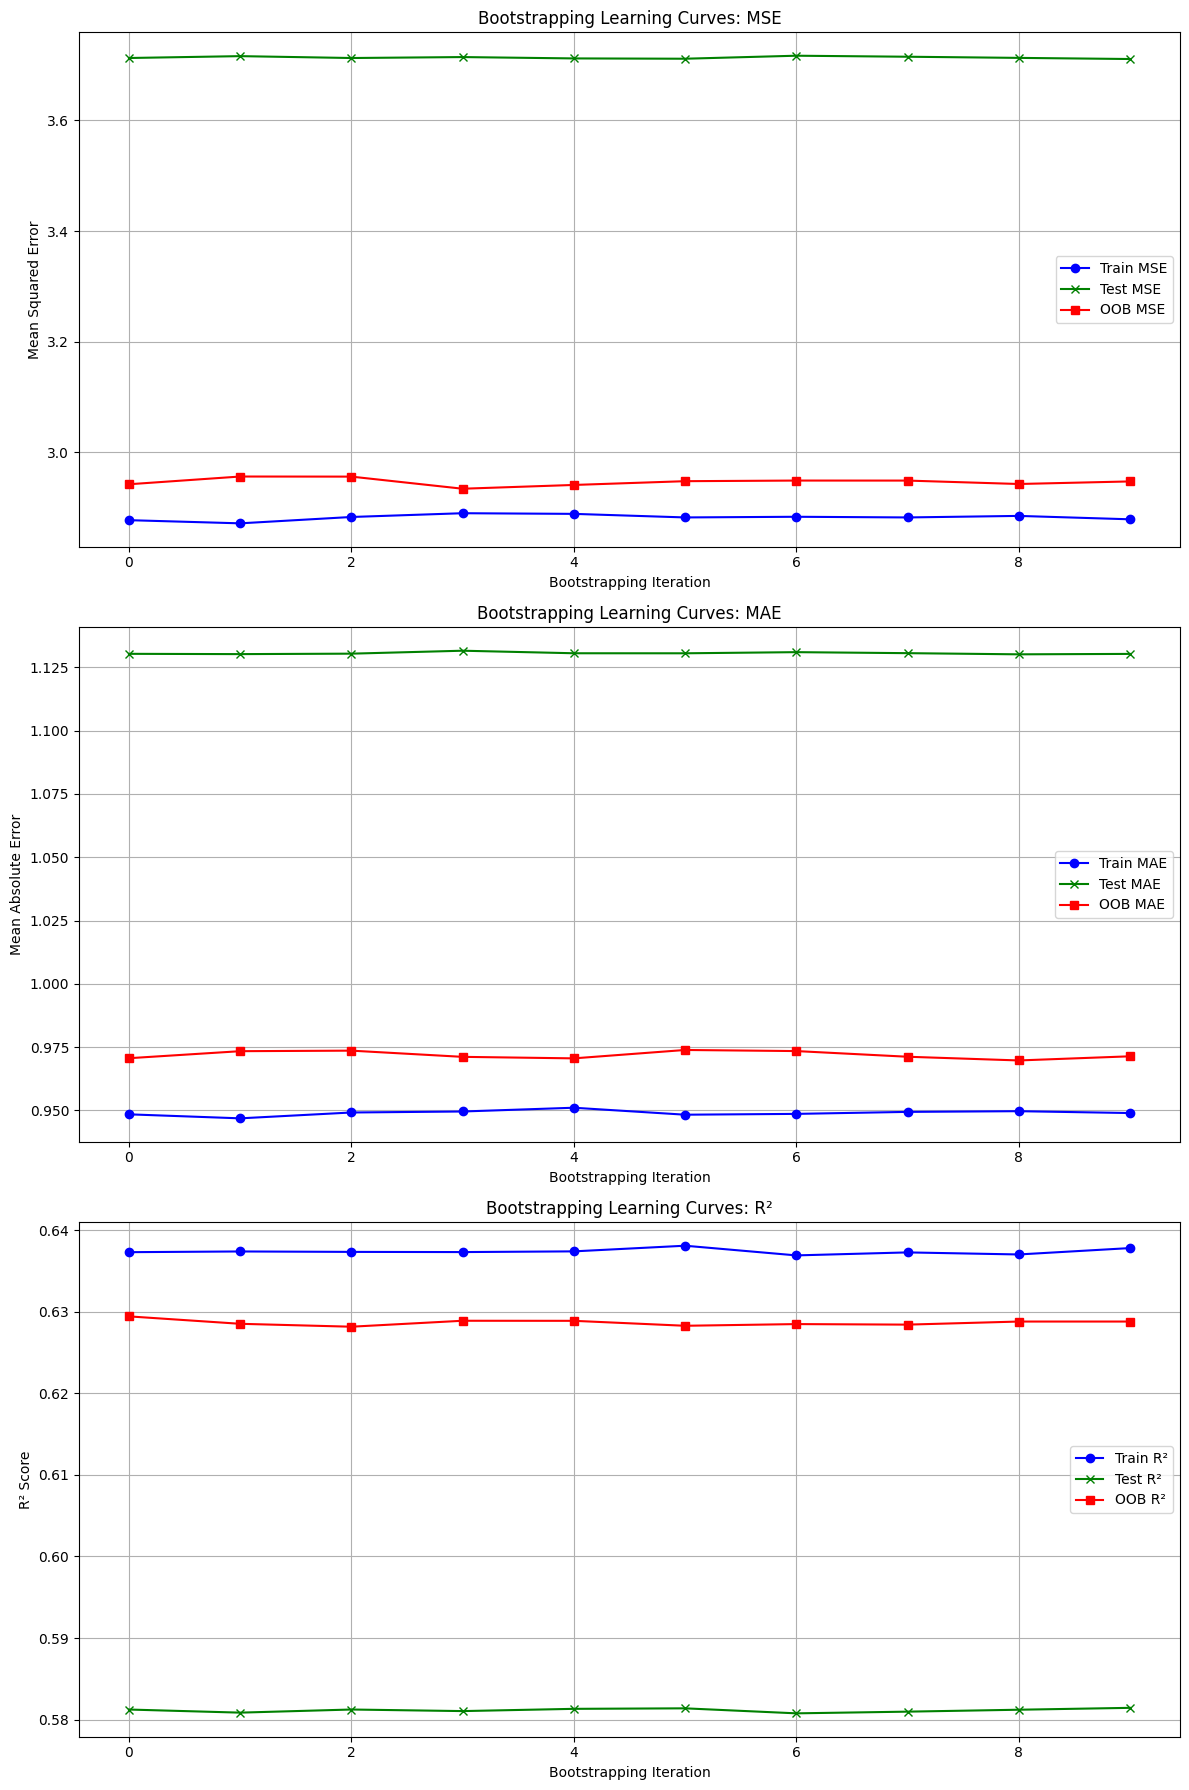

In [45]:
# 9. Model Evaluation: Learning Curves and Performance Visualization
import matplotlib.pyplot as plt

# Number of bootstrapping iterations
iterations = range(n_iterations)

# Plotting learning curves for Train, Test, and OOB MSE, MAE, and R²
fig, axs = plt.subplots(3, 1, figsize=(12, 18))

# Mean Squared Error (MSE) Learning Curves
axs[0].plot(iterations, metrics['train_mse'], label="Train MSE", color="blue", marker="o")
axs[0].plot(iterations, metrics['test_mse'], label="Test MSE", color="green", marker="x")
axs[0].plot(iterations, metrics['oob_mse'], label="OOB MSE", color="red", marker="s")
axs[0].set_xlabel("Bootstrapping Iteration")
axs[0].set_ylabel("Mean Squared Error")
axs[0].set_title("Bootstrapping Learning Curves: MSE")
axs[0].legend()
axs[0].grid(True)

# Mean Absolute Error (MAE) Learning Curves
axs[1].plot(iterations, metrics['train_mae'], label="Train MAE", color="blue", marker="o")
axs[1].plot(iterations, metrics['test_mae'], label="Test MAE", color="green", marker="x")
axs[1].plot(iterations, metrics['oob_mae'], label="OOB MAE", color="red", marker="s")
axs[1].set_xlabel("Bootstrapping Iteration")
axs[1].set_ylabel("Mean Absolute Error")
axs[1].set_title("Bootstrapping Learning Curves: MAE")
axs[1].legend()
axs[1].grid(True)

# R² Score Learning Curves
axs[2].plot(iterations, metrics['train_r2'], label="Train R²", color="blue", marker="o")
axs[2].plot(iterations, metrics['test_r2'], label="Test R²", color="green", marker="x")
axs[2].plot(iterations, metrics['oob_r2'], label="OOB R²", color="red", marker="s")
axs[2].set_xlabel("Bootstrapping Iteration")
axs[2].set_ylabel("R² Score")
axs[2].set_title("Bootstrapping Learning Curves: R²")
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()


**10. Training on a Random Forest instead of a Decision Tree. All steps included below for simplicity and ease of code reproduction.**

Iteration 1:
  Train MSE: 2.8782, MAE: 0.9495, R2: 0.6372
  Test MSE: 3.7098, MAE: 1.1294, R2: 0.5816
  OOB MSE: 2.9387, MAE: 0.9696, R2: 0.6299
Iteration 2:
  Train MSE: 2.8725, MAE: 0.9479, R2: 0.6373
  Test MSE: 3.7118, MAE: 1.1291, R2: 0.5814
  OOB MSE: 2.9521, MAE: 0.9724, R2: 0.6291
Iteration 3:
  Train MSE: 2.8840, MAE: 0.9502, R2: 0.6372
  Test MSE: 3.7095, MAE: 1.1294, R2: 0.5816
  OOB MSE: 2.9501, MAE: 0.9725, R2: 0.6289
Iteration 4:
  Train MSE: 2.8907, MAE: 0.9506, R2: 0.6372
  Test MSE: 3.7106, MAE: 1.1304, R2: 0.5815
  OOB MSE: 2.9294, MAE: 0.9700, R2: 0.6295
Iteration 5:
  Train MSE: 2.8895, MAE: 0.9521, R2: 0.6373
  Test MSE: 3.7089, MAE: 1.1296, R2: 0.5817
  OOB MSE: 2.9371, MAE: 0.9696, R2: 0.6294
Iteration 6:
  Train MSE: 2.8831, MAE: 0.9493, R2: 0.6380
  Test MSE: 3.7083, MAE: 1.1295, R2: 0.5818
  OOB MSE: 2.9442, MAE: 0.9728, R2: 0.6288
Iteration 7:
  Train MSE: 2.8844, MAE: 0.9496, R2: 0.6368
  Test MSE: 3.7117, MAE: 1.1297, R2: 0.5814
  OOB MSE: 2.9429, MAE: 0.97

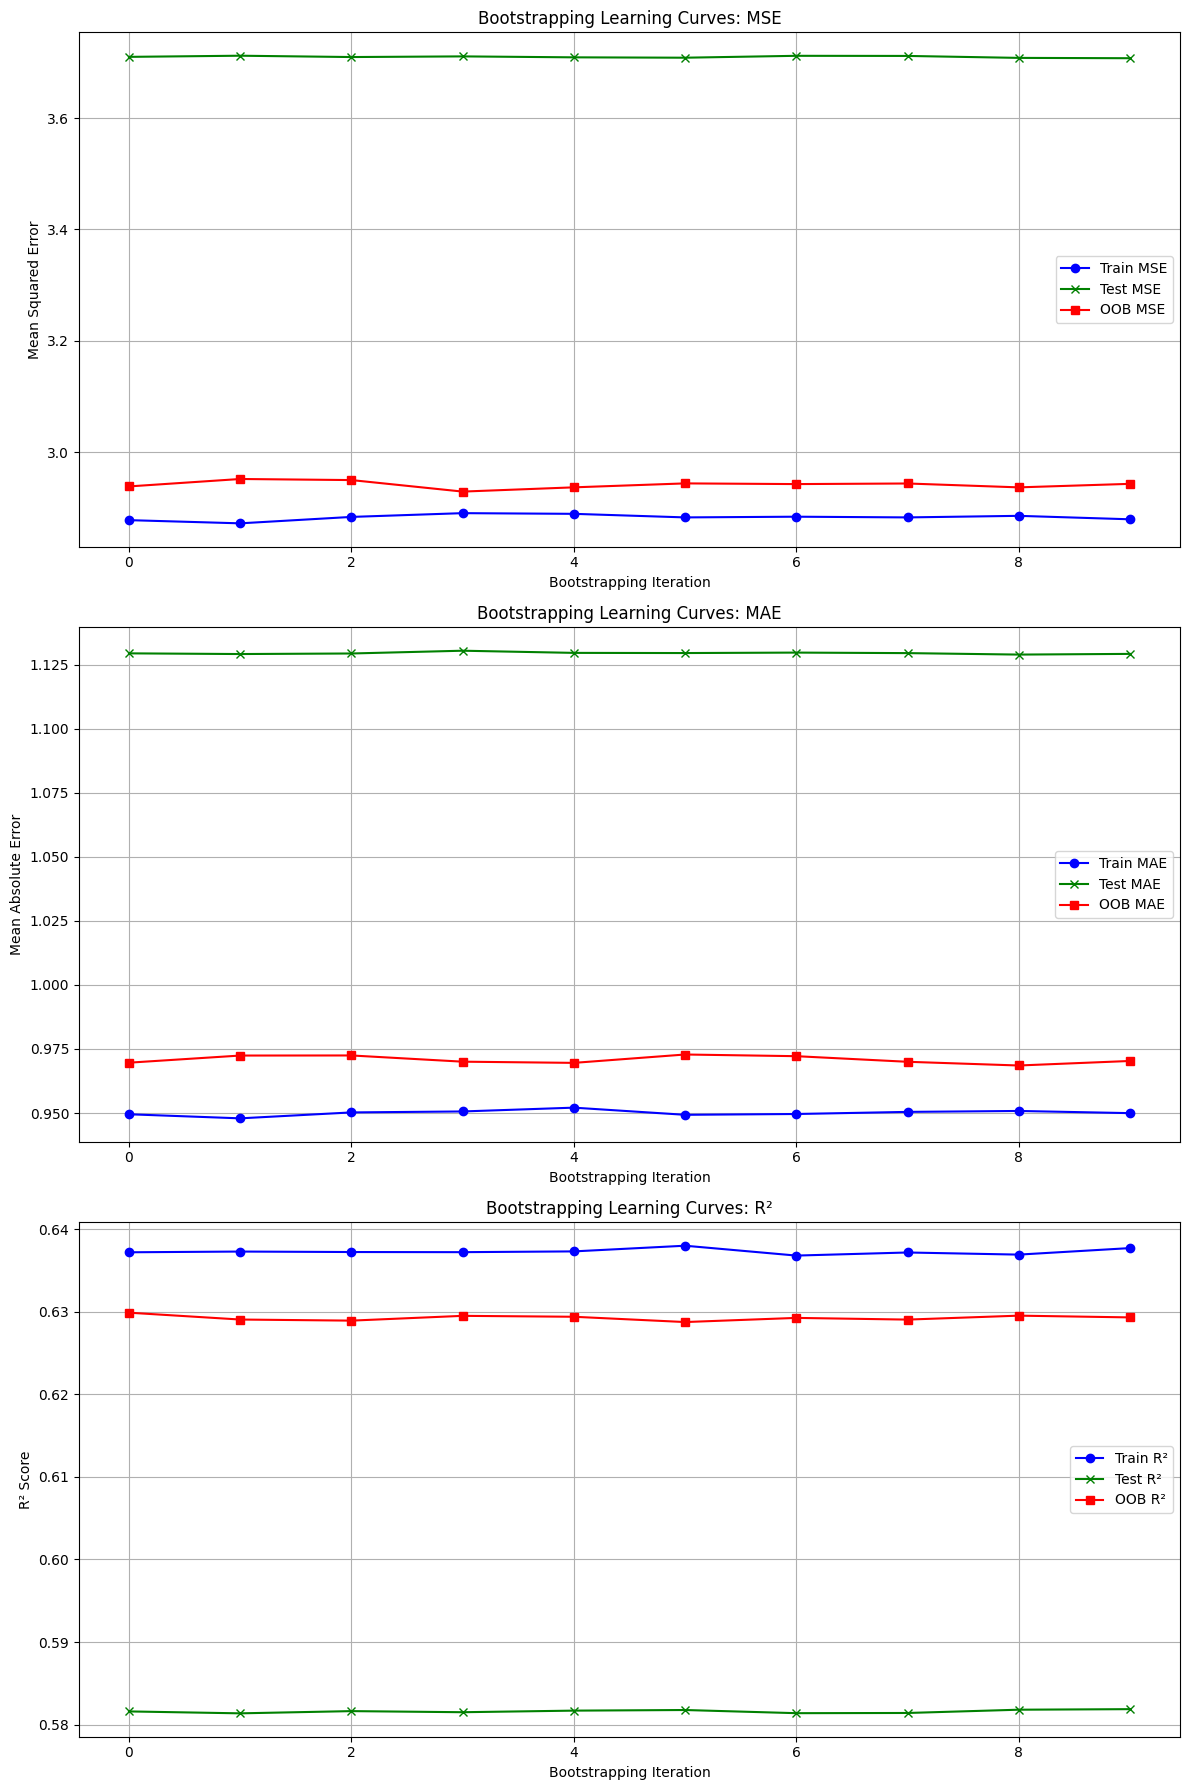

In [32]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Parameters
n_iterations = 10
n_estimators = 100  # Number of trees in the forest

# Store metrics for each bootstrap iteration
metrics = {
    'train_mse': [], 'train_mae': [], 'train_r2': [],
    'test_mse': [], 'test_mae': [], 'test_r2': [],
    'oob_mse': [], 'oob_mae': [], 'oob_r2': []
}

# Separate features and target in the test set for evaluation
X_test = test_data.drop('sst', axis=1)
y_test = test_data['sst']

# Bootstrapping loop
for i in range(n_iterations):
    # Sample with replacement from the training set for bootstrap
    bootstrapped_data = train_data.sample(frac=1, replace=True, random_state=i)
    X_train = bootstrapped_data.drop('sst', axis=1)
    y_train = bootstrapped_data['sst']
    
    # Identify out-of-bag (OOB) samples for this iteration
    oob_data = train_data.loc[~train_data.index.isin(bootstrapped_data.index)]
    X_oob = oob_data.drop('sst', axis=1)
    y_oob = oob_data['sst']
    
    # Initialize and train RandomForestRegressor on the bootstrap sample
    model = RandomForestRegressor(n_estimators=n_estimators, oob_score=True, random_state=i)
    model.fit(X_train, y_train)
    
    # Predict on train, test, and OOB data
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)
    oob_predictions = model.predict(X_oob) if not oob_data.empty else np.nan
    
    # Calculate metrics for train set
    train_mse = mean_squared_error(y_train, train_predictions)
    train_mae = mean_absolute_error(y_train, train_predictions)
    train_r2 = r2_score(y_train, train_predictions)
    
    # Calculate metrics for test set
    test_mse = mean_squared_error(y_test, test_predictions)
    test_mae = mean_absolute_error(y_test, test_predictions)
    test_r2 = r2_score(y_test, test_predictions)
    
    # Calculate metrics for OOB samples
    if not np.isnan(oob_predictions).all():
        oob_mse = mean_squared_error(y_oob, oob_predictions)
        oob_mae = mean_absolute_error(y_oob, oob_predictions)
        oob_r2 = r2_score(y_oob, oob_predictions)
    else:
        oob_mse = oob_mae = oob_r2 = np.nan
    
    # Append metrics
    metrics['train_mse'].append(train_mse)
    metrics['train_mae'].append(train_mae)
    metrics['train_r2'].append(train_r2)
    
    metrics['test_mse'].append(test_mse)
    metrics['test_mae'].append(test_mae)
    metrics['test_r2'].append(test_r2)
    
    metrics['oob_mse'].append(oob_mse)
    metrics['oob_mae'].append(oob_mae)
    metrics['oob_r2'].append(oob_r2)
    
    # Print the metrics for this bootstrap iteration
    print(f"Iteration {i+1}:")
    print(f"  Train MSE: {train_mse:.4f}, MAE: {train_mae:.4f}, R2: {train_r2:.4f}")
    print(f"  Test MSE: {test_mse:.4f}, MAE: {test_mae:.4f}, R2: {test_r2:.4f}")
    if not np.isnan(oob_mse):
        print(f"  OOB MSE: {oob_mse:.4f}, MAE: {oob_mae:.4f}, R2: {oob_r2:.4f}")
    else:
        print("  OOB data not available for this iteration")

# Calculate and display average metrics across all bootstraps
average_metrics = {key: np.nanmean(values) for key, values in metrics.items()}
print("\nAverage Metrics Across Bootstraps:")
for metric, value in average_metrics.items():
    print(f"{metric}: {value:.4f}")

# Plotting learning curves for Train, Test, and OOB MSE, MAE, and R²
iterations = range(n_iterations)
fig, axs = plt.subplots(3, 1, figsize=(12, 18))

# Mean Squared Error (MSE) Learning Curves
axs[0].plot(iterations, metrics['train_mse'], label="Train MSE", color="blue", marker="o")
axs[0].plot(iterations, metrics['test_mse'], label="Test MSE", color="green", marker="x")
axs[0].plot(iterations, metrics['oob_mse'], label="OOB MSE", color="red", marker="s")
axs[0].set_xlabel("Bootstrapping Iteration")
axs[0].set_ylabel("Mean Squared Error")
axs[0].set_title("Bootstrapping Learning Curves: MSE")
axs[0].legend()
axs[0].grid(True)

# Mean Absolute Error (MAE) Learning Curves
axs[1].plot(iterations, metrics['train_mae'], label="Train MAE", color="blue", marker="o")
axs[1].plot(iterations, metrics['test_mae'], label="Test MAE", color="green", marker="x")
axs[1].plot(iterations, metrics['oob_mae'], label="OOB MAE", color="red", marker="s")
axs[1].set_xlabel("Bootstrapping Iteration")
axs[1].set_ylabel("Mean Absolute Error")
axs[1].set_title("Bootstrapping Learning Curves: MAE")
axs[1].legend()
axs[1].grid(True)

# R² Score Learning Curves
axs[2].plot(iterations, metrics['train_r2'], label="Train R²", color="blue", marker="o")
axs[2].plot(iterations, metrics['test_r2'], label="Test R²", color="green", marker="x")
axs[2].plot(iterations, metrics['oob_r2'], label="OOB R²", color="red", marker="s")
axs[2].set_xlabel("Bootstrapping Iteration")
axs[2].set_ylabel("R² Score")
axs[2].set_title("Bootstrapping Learning Curves: R²")
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()


**11. Visualizing just the errors associated with the test data. The results are very similar for both the decision tree and random forest, and thus the decision tree results are excluded below. Note that a very similar answer would be given.**

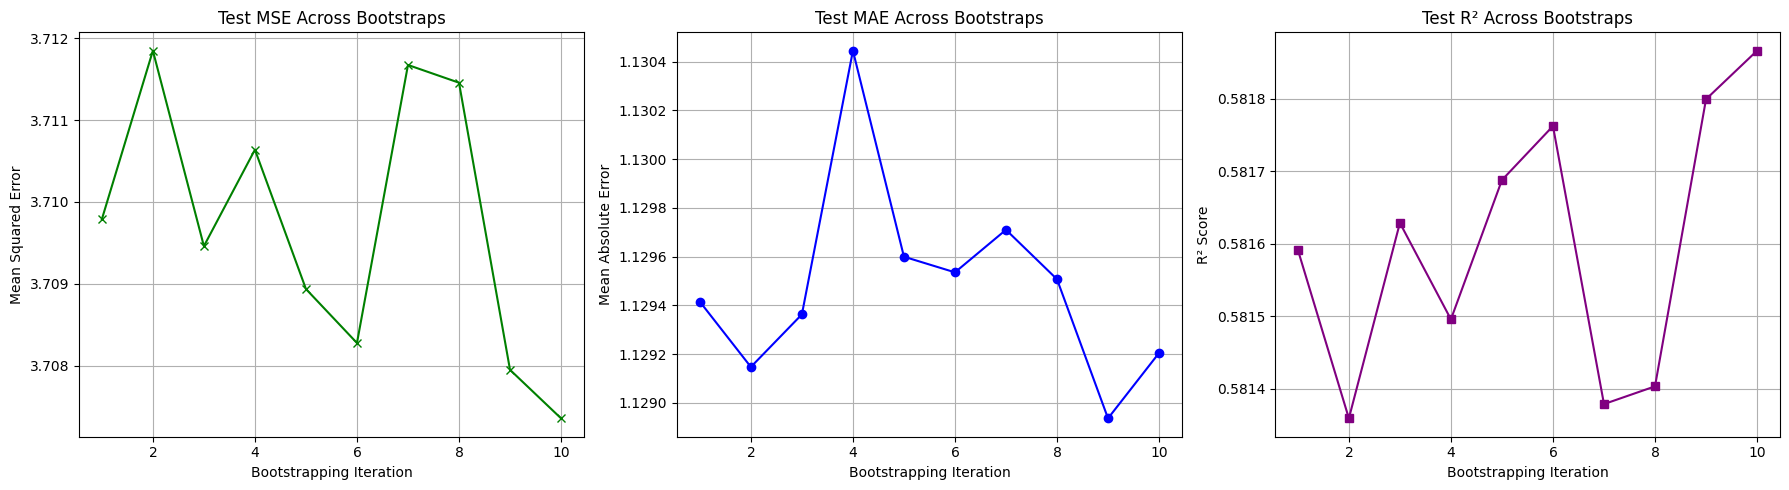

In [33]:
import matplotlib.pyplot as plt

# Number of bootstrapping iterations
iterations = range(1, n_iterations + 1)

# Creating a figure with subplots for each test metric
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Plotting Test Mean Squared Error (MSE)
ax[0].plot(iterations, metrics['test_mse'], color="green", marker="x", linestyle="-", label="Test MSE")
ax[0].set_xlabel("Bootstrapping Iteration")
ax[0].set_ylabel("Mean Squared Error")
ax[0].set_title("Test MSE Across Bootstraps")
ax[0].grid(True)

# Plotting Test Mean Absolute Error (MAE)
ax[1].plot(iterations, metrics['test_mae'], color="blue", marker="o", linestyle="-", label="Test MAE")
ax[1].set_xlabel("Bootstrapping Iteration")
ax[1].set_ylabel("Mean Absolute Error")
ax[1].set_title("Test MAE Across Bootstraps")
ax[1].grid(True)

# Plotting Test R² Score
ax[2].plot(iterations, metrics['test_r2'], color="purple", marker="s", linestyle="-", label="Test R²")
ax[2].set_xlabel("Bootstrapping Iteration")
ax[2].set_ylabel("R² Score")
ax[2].set_title("Test R² Across Bootstraps")
ax[2].grid(True)

plt.tight_layout()
plt.show()


**12. Finally, just testing these results against linear regression to prove that the data is not purely linear and that a decision tree regressor performs better.**

Iteration 1:
  Train MSE: 3.9225, MAE: 1.4035, R2: 0.5056
  Test MSE: 4.7665, MAE: 1.5562, R2: 0.4624
  OOB MSE: 3.9238, MAE: 1.4035, R2: 0.5058
Iteration 2:
  Train MSE: 3.9143, MAE: 1.4016, R2: 0.5057
  Test MSE: 4.7671, MAE: 1.5553, R2: 0.4623
  OOB MSE: 3.9372, MAE: 1.4059, R2: 0.5053
Iteration 3:
  Train MSE: 3.9347, MAE: 1.4061, R2: 0.5051
  Test MSE: 4.7663, MAE: 1.5565, R2: 0.4624
  OOB MSE: 3.9245, MAE: 1.4034, R2: 0.5064
Iteration 4:
  Train MSE: 3.9396, MAE: 1.4068, R2: 0.5056
  Test MSE: 4.7657, MAE: 1.5575, R2: 0.4625
  OOB MSE: 3.9061, MAE: 1.4025, R2: 0.5060
Iteration 5:
  Train MSE: 3.9386, MAE: 1.4078, R2: 0.5056
  Test MSE: 4.7658, MAE: 1.5573, R2: 0.4625
  OOB MSE: 3.9177, MAE: 1.4038, R2: 0.5057
Iteration 6:
  Train MSE: 3.9341, MAE: 1.4057, R2: 0.5060
  Test MSE: 4.7657, MAE: 1.5574, R2: 0.4625
  OOB MSE: 3.9212, MAE: 1.4056, R2: 0.5056
Iteration 7:
  Train MSE: 3.9290, MAE: 1.4041, R2: 0.5053
  Test MSE: 4.7665, MAE: 1.5561, R2: 0.4624
  OOB MSE: 3.9236, MAE: 1.40

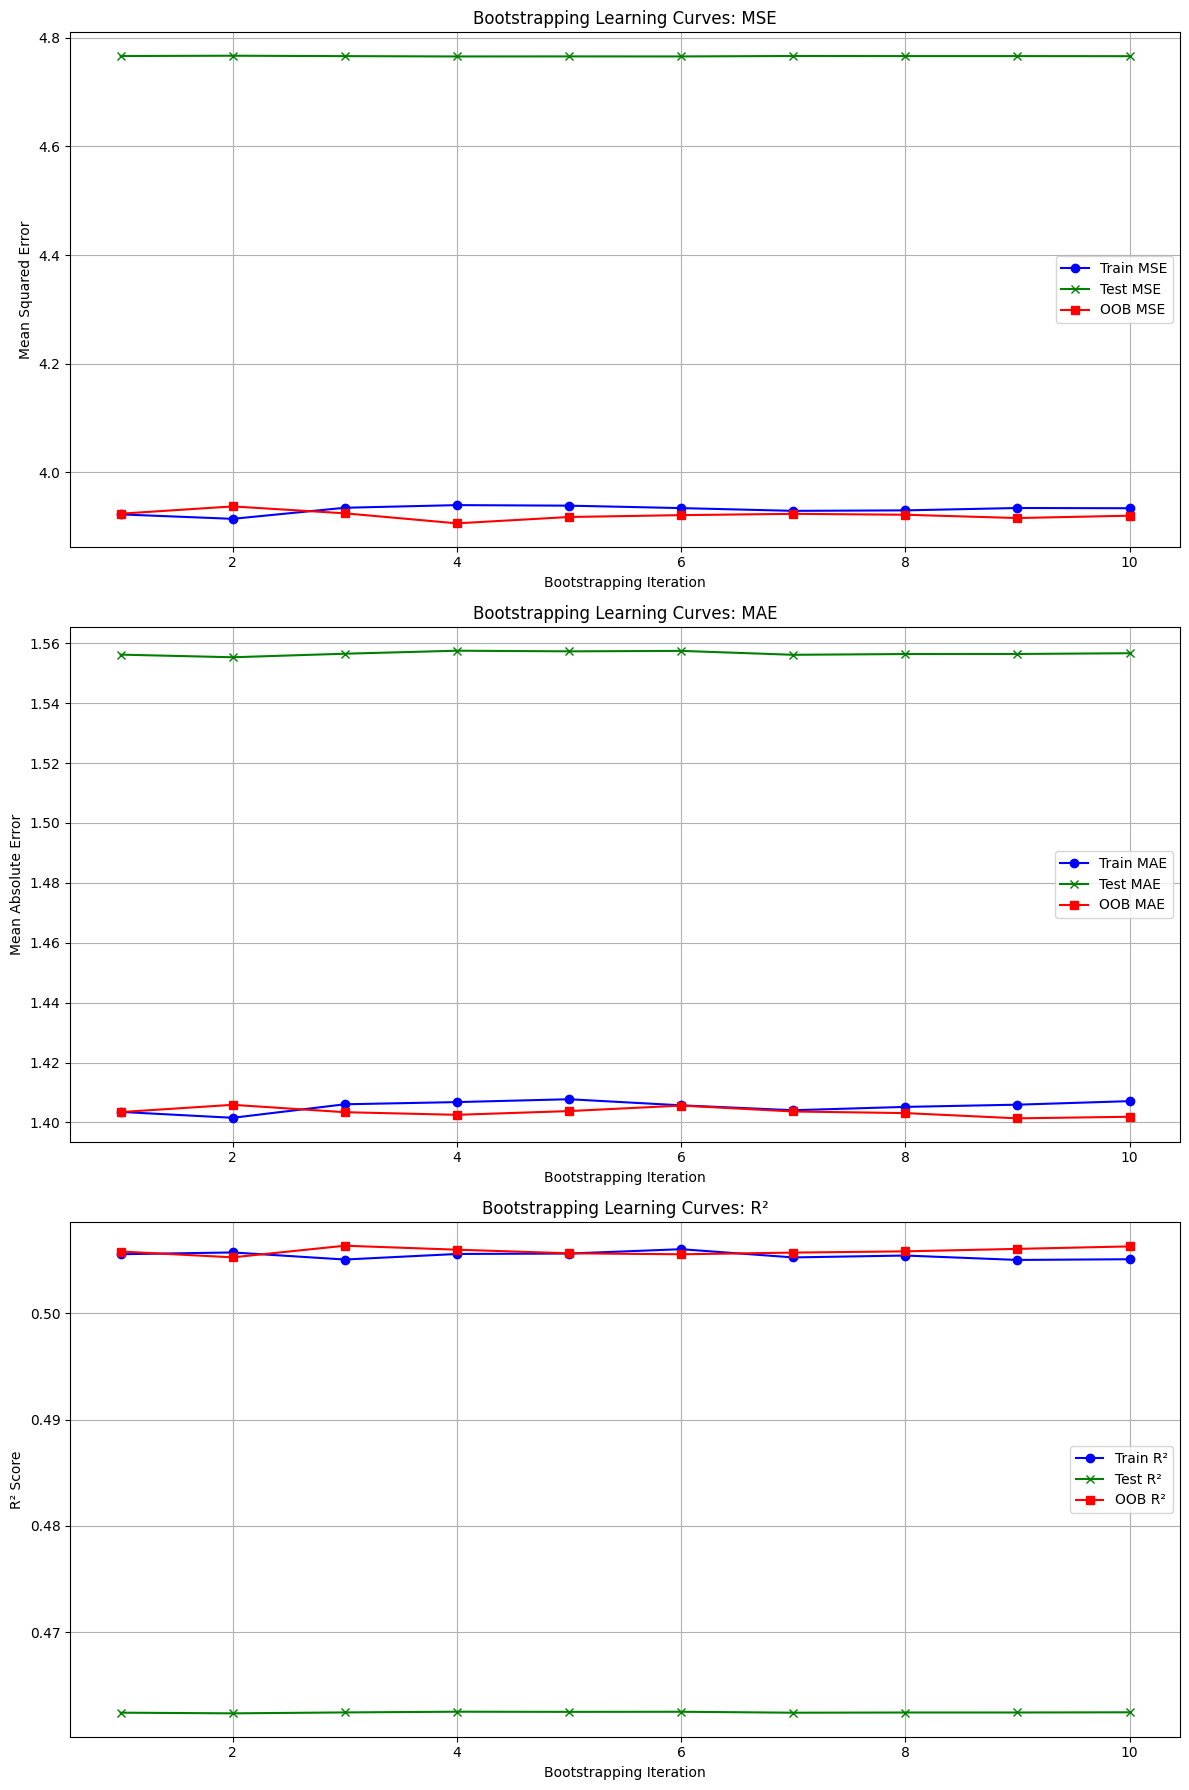

In [30]:
# 12. Testing a Linear Regression Model with Bootstrapping to see if it matches the Random Forest / Decision Tree results
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Bootstrapping parameters
n_iterations = 10  # Number of bootstraps
train_errors, test_errors, oob_errors = [], [], []

# Store models and metrics for each bootstrap iteration
models = []
metrics = {
    'train_mse': [], 'train_mae': [], 'train_r2': [],
    'test_mse': [], 'test_mae': [], 'test_r2': [],
    'oob_mse': [], 'oob_mae': [], 'oob_r2': []
}

# Separate features and target in test set for evaluation
X_test = test_data.drop('sst', axis=1)
y_test = test_data['sst']

# Bootstrapping loop
for i in range(n_iterations):
    # Sample with replacement from the training set for bootstrap
    bootstrapped_data = train_data.sample(frac=1, replace=True, random_state=i)
    X_train = bootstrapped_data.drop('sst', axis=1)
    y_train = bootstrapped_data['sst']
    
    # Identify out-of-bag (OOB) samples for this iteration
    oob_data = train_data.loc[~train_data.index.isin(bootstrapped_data.index)]
    X_oob = oob_data.drop('sst', axis=1)
    y_oob = oob_data['sst']
    
    # Train the linear regression model on the bootstrap sample
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Store the trained model
    models.append(model)
    
    # Predict on train, test, and OOB data
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)
    oob_predictions = model.predict(X_oob) if not oob_data.empty else None
    
    # Calculate metrics for train set
    train_mse = mean_squared_error(y_train, train_predictions)
    train_mae = mean_absolute_error(y_train, train_predictions)
    train_r2 = r2_score(y_train, train_predictions)
    
    # Calculate metrics for test set
    test_mse = mean_squared_error(y_test, test_predictions)
    test_mae = mean_absolute_error(y_test, test_predictions)
    test_r2 = r2_score(y_test, test_predictions)
    
    # Calculate metrics for OOB samples if available
    if oob_predictions is not None:
        oob_mse = mean_squared_error(y_oob, oob_predictions)
        oob_mae = mean_absolute_error(y_oob, oob_predictions)
        oob_r2 = r2_score(y_oob, oob_predictions)
    else:
        oob_mse = oob_mae = oob_r2 = np.nan  # No OOB samples
    
    # Append metrics
    metrics['train_mse'].append(train_mse)
    metrics['train_mae'].append(train_mae)
    metrics['train_r2'].append(train_r2)
    
    metrics['test_mse'].append(test_mse)
    metrics['test_mae'].append(test_mae)
    metrics['test_r2'].append(test_r2)
    
    metrics['oob_mse'].append(oob_mse)
    metrics['oob_mae'].append(oob_mae)
    metrics['oob_r2'].append(oob_r2)
    
    # Print the metrics for this bootstrap iteration
    print(f"Iteration {i+1}:")
    print(f"  Train MSE: {train_mse:.4f}, MAE: {train_mae:.4f}, R2: {train_r2:.4f}")
    print(f"  Test MSE: {test_mse:.4f}, MAE: {test_mae:.4f}, R2: {test_r2:.4f}")
    if not np.isnan(oob_mse):
        print(f"  OOB MSE: {oob_mse:.4f}, MAE: {oob_mae:.4f}, R2: {oob_r2:.4f}")
    else:
        print("  OOB data not available for this iteration")

# Calculate and display average metrics across all bootstraps
average_metrics = {key: np.nanmean(values) for key, values in metrics.items()}
print("\nAverage Metrics Across Bootstraps:")
for metric, value in average_metrics.items():
    print(f"{metric}: {value:.4f}")

# Plotting learning curves for Train, Test, and OOB MSE, MAE, and R²
iterations = range(1, n_iterations + 1)

fig, axs = plt.subplots(3, 1, figsize=(12, 18))

# Mean Squared Error (MSE) Learning Curves
axs[0].plot(iterations, metrics['train_mse'], label="Train MSE", color="blue", marker="o")
axs[0].plot(iterations, metrics['test_mse'], label="Test MSE", color="green", marker="x")
axs[0].plot(iterations, metrics['oob_mse'], label="OOB MSE", color="red", marker="s")
axs[0].set_xlabel("Bootstrapping Iteration")
axs[0].set_ylabel("Mean Squared Error")
axs[0].set_title("Bootstrapping Learning Curves: MSE")
axs[0].legend()
axs[0].grid(True)

# Mean Absolute Error (MAE) Learning Curves
axs[1].plot(iterations, metrics['train_mae'], label="Train MAE", color="blue", marker="o")
axs[1].plot(iterations, metrics['test_mae'], label="Test MAE", color="green", marker="x")
axs[1].plot(iterations, metrics['oob_mae'], label="OOB MAE", color="red", marker="s")
axs[1].set_xlabel("Bootstrapping Iteration")
axs[1].set_ylabel("Mean Absolute Error")
axs[1].set_title("Bootstrapping Learning Curves: MAE")
axs[1].legend()
axs[1].grid(True)

# R² Score Learning Curves
axs[2].plot(iterations, metrics['train_r2'], label="Train R²", color="blue", marker="o")
axs[2].plot(iterations, metrics['test_r2'], label="Test R²", color="green", marker="x")
axs[2].plot(iterations, metrics['oob_r2'], label="OOB R²", color="red", marker="s")
axs[2].set_xlabel("Bootstrapping Iteration")
axs[2].set_ylabel("R² Score")
axs[2].set_title("Bootstrapping Learning Curves: R²")
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()


**13. RESULTS:**

As was shown in the *automl_hyperparameter_tuning.ipynb*, the decision tree regressor performs the best among the models to use for sea surface temperature analysis. This is due to the higher R² value when compared to simple linear regression. This suggests a very meaningful result -- there are non linear feedbacks at play controlling ice loss over the observational period. If the simple linear regression would have performed as well as the decision tree, then one could argue that in the Barents-Kara sea region, that the retreat of ice is linear with climate change. Since this was not the case, we have gained a key insight into non-linear feedbacks on the sea ice over the observational period.

Note that we are basing our results off of the subsetted region in the Barents-Kara sea, and that we are training the model on all of the available data and testing it on 10 random years from within the data. Originally, we were trying to train the model on the years 1979-2010 and then have it predict 2011 onwards. This led to very low R² values as well as high mean squared error because of the nonlinearities present within the sea surface temperature (SST) data. The ice-albedo feedback loop is not linear and thus trying to predict the non-linear nature of this feedback over the short observational period is difficult. One way that people may improve upon these results is to run climate simulations that capture the physics of future ice-albedo feedbacks. This way allow the ML framework to better visualize future warming scenarios and their impacts on sea ice concentration (SIC) and SST.